=== Processing Waypoint = Falklands ===
=== Processing Waypoint = SouthGeorgia ===


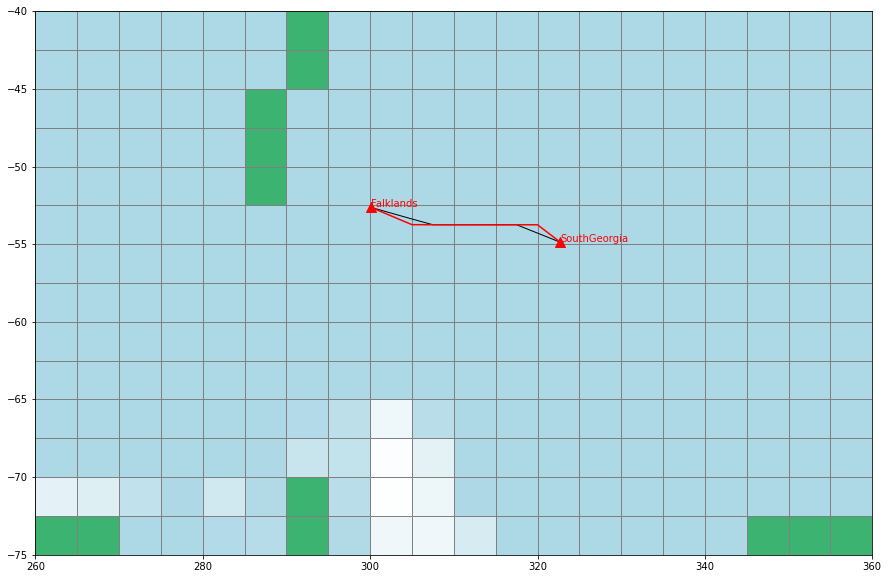

In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid

#read in Ice  & Currents Points
icePoints     = pd.read_json('../resources/icepoints2019-02-08.json')
icePoints     = pd.DataFrame.from_records(icePoints.icepoints)
currentPoints = pd.read_json('../resources/currentPoints.json')
currentPoints = pd.DataFrame.from_records(currentPoints.currentPoints)

longMin    = 260
longMax    = 360
latMin     = -75
latMax     = -40
cellWidth  = 5
cellHeight = 2.5

cellGrid = CellGrid(longMin, longMax, latMin, latMax, cellWidth, cellHeight)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)

from RoutePlanner.Optimisation import TravelTime
OptInfo = {}
OptInfo['WayPoints']            = pd.read_csv('../resources/WayPoints_SmoothingLatitude.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3 #Units km/hr

TT = TravelTime(cellGrid,OptInfo)
TT.Dijkstra(verbrose=True)
ax = TT.PlotPaths(waypoints=['Falklands'])


In [2]:
from RoutePlanner.Function import NewtonianCurve

In [3]:
import numpy as np
from tqdm import tqdm

Path = TT.Paths[0]


startPoint = Path['Path']['FullPath'][0,:][None,:]
endPoint   = Path['Path']['FullPath'][-1,:][None,:]

OrgcrossingPoints = np.concatenate([startPoint,
                                 Path['Path']['CrossingPoints'],
                                 endPoint])

ax.scatter(OrgcrossingPoints[:,0],OrgcrossingPoints[:,1],15,'b')
ax.plot(OrgcrossingPoints[:,0],OrgcrossingPoints[:,1],'b')

Points = OrgcrossingPoints.copy()
iter=0
for iter in tqdm(range(20)):
    for id in range(Points.shape[0]-2):
        Sp  = tuple(Points[id,:])
        Cp  = tuple(Points[id+1,:])
        Np  = tuple(Points[id+2,:])
        nc = NewtonianCurve(TT.Mesh,Sp,Cp,Np,TT.OptInfo['VehicleInfo']['Speed'],debugging=0,maxiter=1500)
        TravelTime, CrossingPoint = nc.value()

        if id == 0:
            newPoints = CrossingPoint
        else:
            newPoints = np.concatenate([newPoints,CrossingPoint])

    Points = np.concatenate([startPoint,newPoints,endPoint])


100%|██████████| 20/20 [00:04<00:00,  4.34it/s]


(-60.0, -50.0)

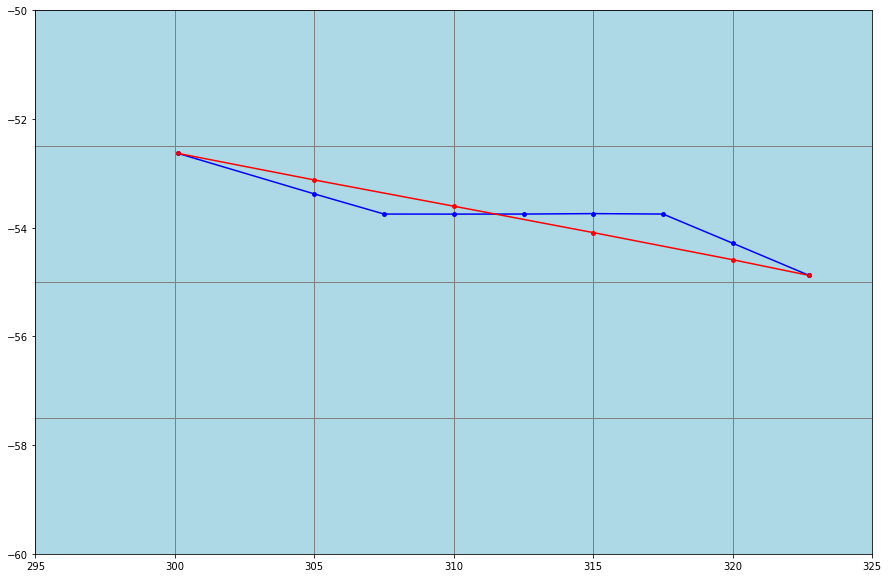

In [5]:
ax = cellGrid.plot(return_ax=True)

crossingPoints = np.concatenate([Path['Path']['FullPath'][0,:][None,:],
                                 Path['Path']['CrossingPoints'],
                                 Path['Path']['FullPath'][-1,:][None,:]])


ax.scatter(Path['Path']['FullPath'][:,0],Path['Path']['FullPath'][:,1],15,'b')
ax.plot(Path['Path']['FullPath'][:,0],Path['Path']['FullPath'][:,1],'b')

ax.scatter(Points[:,0],Points[:,1],15,'r')
ax.plot(Points[:,0],Points[:,1],'r')

# ax.plot(GT['Long'],GT['Lat'],'k')
ax.set_xlim([295,325])
ax.set_ylim([-60,-50])